# OCR MNIST DIGITS - Self programmed

The objective of this notebook is to make an OCR with neural networks.
This is exercise is for learning purpose, so do not expect an optimized solution.
The data used shall be MNIST digits.

The problem is obtained from:

https://www.kaggle.com/c/digit-recognizer/data



# Import libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Data

Data is in file "train.csv".

First column: label y (from 0->9)

Following 784 columns: pixels in order 28X28

Pixels range value: 0..255

## Import data:

In [2]:
data_train=np.genfromtxt("train.csv", unpack=True, skip_header=1,delimiter=",")

## Normalization of data:

Usually in a Deep learning problem it is used: training data, cross-validation data and test data. Kaggle problem gives a specific set for test data that is used to check the full model.

Note that usually (for example in Tensorflow) in data matrix, the data is ordered: (training sample,data). However, in this exercise, data shall be ordered (data,training sample).

In [3]:
print("Full training data shape: (%d, %d)" % data_train.shape)

# NC: number of categories
NC=10

# NP: number of pixels in the image
NP=round((data_train.shape[0]-1)**0.5)

# m: number of data images provided
m=data_train.shape[1]

# 90% training / 10% cross validation aprox.
m_CV=4000
m_train=m-m_CV

print("Training data: ",m_train)
print("Cross Validation data: ",m_CV)

# Train data
## Label
### Sparse categorical
y_train=data_train[0,0:m_train].reshape(1,-1)
### One_hot categorical
Y_train=np.zeros((10,y_train.shape[1]))
Y_train[y_train.astype(int),range(y_train.shape[1])]=1
## Image data
xx_train=data_train[1:data_train.shape[0],0:m_train]/255
### Around each digit there is a black frame which can be removed. Cut gives the number of pixels removed from the frame.
cut=0
x_train=((xx_train.T.reshape(m_train,NP,NP))[:,cut:NP-cut,cut:NP-cut].reshape(m_train,-1)).T

# Train data
## Label
### Sparse categorical
y_CV=data_train[0,m_train:].reshape(1,-1)
### One_hot categorical
Y_CV=np.zeros((10,y_CV.shape[1]))
Y_CV[y_CV.astype(int),range(y_CV.shape[1])]=1
## Image data
xx_CV=data_train[1:data_train.shape[0],m_train:]/255
x_CV=((xx_CV.T.reshape(m_CV,NP,NP))[:,cut:NP-cut,cut:NP-cut].reshape(m_CV,-1)).T

print("x training data shape: (%d, %d)" % x_train.shape)
print("Y training data shape: (%d, %d)" % Y_train.shape)
print("x CV data shape: (%d, %d)" % x_CV.shape)
print("Y CV data shape: (%d, %d)" % Y_CV.shape)
print("Number of training data: %d" % m_train)
n_x=x_train.shape[0]
print("Number of features: %d" % n_x)
NP=NP-2*cut
print("Images are: %d x %d" %(NP,NP))

Full training data shape: (785, 42000)
Training data:  38000
Cross Validation data:  4000
x training data shape: (784, 38000)
Y training data shape: (10, 38000)
x CV data shape: (784, 4000)
Y CV data shape: (10, 4000)
Number of training data: 38000
Number of features: 784
Images are: 28 x 28


## Understanding of the data:

Following picture is label as 3
(28, 28)


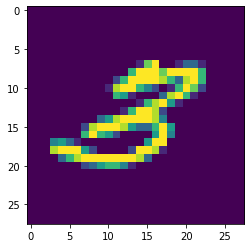

In [4]:
example2plot=1050
print("Following picture is label as %d" % y_train[0,example2plot])
example=(x_train[:,example2plot].reshape(NP,NP))
print(example.shape)
imgplot = plt.imshow(example)



# Definition of activation functions

In [5]:
def relu(z):
    return ((z>0)*z).reshape(z.shape[0],z.shape[1])

In [6]:
def relu_derivate(z):
    return ((z>0)*1).reshape(z.shape[0],z.shape[1])

In [7]:
def sigmoid(z):
    return (1/(1+np.exp(-z))).reshape(z.shape[0],z.shape[1])

In [8]:
def sigmoid_derivate(z):
    aux=sigmoid(z)
    return (aux*(1-aux)).reshape(z.shape[0],z.shape[1])

In [9]:
def softmax(z):
    return (np.exp(z)/((np.exp(z)).sum(axis=0)).reshape(1,z.shape[1])).reshape(z.shape[0],z.shape[1])

# Definition of the neural network parameters

In [10]:
# Number of layers
L=3

# Neurons per layer
n_h=[324,324,10]

# Type of activation at each layer
typeN=["relu","relu","softmax"]

for i in range(L):
    print("Layer %d: has %d neurons of type %s" % (i+1, n_h[i], typeN[i]))

Layer 1: has 324 neurons of type relu
Layer 2: has 324 neurons of type relu
Layer 3: has 10 neurons of type softmax


# NN Model functions

## Function to initialize

**For relu / linear:**

In initialitation, the factor *np.sqrt(2/nn[l])* is applied to avoid canishing/exploding gradients in large deep neural networks.

**For sigmoid / softmax:**

In initialitation, the factor *np.sqrt(1/nn[l])* is applied to avoid canishing/exploding gradients in large deep neural networks.

In [11]:
def initialize_NN(L,n_x,n_h,typeN):
    ## This function initialize the neural network creating a dictionary call parameters.
    ## INPUTS
    ##### L: number of layers
    ##### n_x: length of input vector
    ##### n_h: list with the number of neurons in each layer
    ##### typeN: type of activation applied at each layer
    ## OUTPUTS
    ##### parameters dictionary, contains "W_" and "b_" of each layer.
    nn=[n_x]+n_h
    parameters={}
    for l in range(L):
        if ((typeN[l]=="relu")|(typeN[l]=="linear")):
            parameters["W"+str(l+1)]=np.random.randn(nn[l+1],nn[l])*np.sqrt(2/nn[l])
        if ((typeN[l]=="sigmoid")|(typeN[l]=="softmax")):
            parameters["W"+str(l+1)]=np.random.randn(nn[l+1],nn[l])*np.sqrt(1/nn[l])
        parameters["b"+str(l+1)]=np.zeros((nn[l+1],1))
    return parameters

## Feedforward functions

In [12]:
def feedforward_layer(parameters,typeN,l,A_prev):
    ## feedforward of a layer
    ## INPUTS:
    ##### parameters: parameters of all the layers ("W_" and "b_")
    ##### typeN: type of activation applied at each layer
    ##### l: current layer that is going to be feedforwarded
    ##### A_prev: activation from previous layer
    ## OUTPUTS
    ##### Z = W @ A_prev + b
    ##### A = Activation(Z)
    
    m=A_prev.shape[1]
    
    W=parameters["W"+str(l)]
    b=parameters["b"+str(l)]
    
    n_h=W.shape[0]
    
    Z=W@A_prev+b
    
    Z=Z.reshape(n_h,m)
    
    if typeN[l-1]=="relu":
        A=relu(Z)
    if typeN[l-1]=="sigmoid":
        A=sigmoid(Z)
    if typeN[l-1]=="softmax":
        A=softmax(Z)
    if typeN[l-1]=="linear":
        A=np.copy(Z)
    return A,Z

In [13]:
def feedforward_model(parameters,typeN,X):
    ## feedforward the complete neural network
    ## INPUTS
    ##### parameters: parameters of all the layers ("W_" and "b_")
    ##### typeN: type of activation applied at each layer
    ##### X: input matrix: (data,training samples)
    ## OUTPUTS
    ##### Z dictionary with the values at every layer
    ##### A dictionary with the value of activations at every layer: A[1],A[2]...A[L]
    
    L=len(parameters)//2
    A={}
    Z={}
    
    A_prev=X
    for l in range(L):
        A[l+1],Z[l+1] = feedforward_layer(parameters,typeN,l+1,A_prev)
        A_prev=A[l+1]
        
    return A,Z
    
    

## Back propagation functions

In [14]:
def backprop_layer(parameters,typeN,l,A_lm1,Z_lm1,grad_l):
    ## backprop of a layer: calculation of dW_l, db_l and gradient respect Z_(l-1) at l-1
    ## INPUTS:
    ##### parameters: parameters of all the layers ("W_" and "b_")
    ##### typeN: type of activation applied at each layer
    ##### l: current layer that is going to be feedforwarded
    ##### A_lm1: activation from layer l-1
    ##### Z_lm1: Z from layer l-1
    ##### grad_l
    ## OUTPUTS
    ##### dW: dcost/dW at layer l
    ##### db: dcost/db at layer l
    ##### grad_lm1: dcost/dZ_(l-1) at layer l-1
        
    m=A_lm1.shape[1]
    W=parameters["W"+str(l)]
    dW=(1/m*grad_l@A_lm1.T).reshape(W.shape[0],W.shape[1])
    db=(1/m*np.sum(grad_l,axis=1,keepdims=True)).reshape(W.shape[0],1)
    if l!=1:
        grad_lm1=(W.T@grad_l)
        if typeN[l-1]=="relu":
            grad_lm1=grad_lm1*relu_derivate(Z_lm1)
        if typeN[l-1]=="sigmoid":
            grad_lm1=grad_lm1*sigmoid_derivate(Z_lm1)
    else:
        grad_lm1=0
    return dW,db,grad_lm1

In [15]:
def backprop_model(parameters,typeN,X,Y,A,Z):
    ## backprop of a layer: calculation of dW_l, db_l and gradient respect Z_(l-1) at l-1
    ## INPUTS:
    ##### parameters: parameters of all the layers ("W_" and "b_")
    ##### typeN: type of activation applied at each layer
    ##### X: input matrix: (data,training samples)
    ##### Y: label in one-hot categorical (label,training samples)
    ##### A dictionary with the value of activations at every layer: A[1],A[2]...A[L]
    ##### Z dictionary with the values at every layer
    ## OUTPUTS
    ##### grads: dictionary containing for each layer [dW_] and [db_]
    L=len(parameters)//2
    ## dcost/dZ_l for last layer is always A[L]-Y independently of activation.
    ## This was checked for relu, linear, sigmoid and softmax, with cross entropy loss
    grad_l=A[L]-Y
    A[0]=X
    Z[0]=X
    grads={}
    for l in range(L,0,-1):
        grads["dW"+str(l)], grads["db"+str(l)], grad_l=backprop_layer(parameters,typeN,l,A[l-1],Z[l-1],grad_l)  
    return grads

In [16]:
def RegularizationL2(parameters,grads,lambda_regularization,m):
    ## Add L2 regularization to grads
    ## INPUTS:
    ##### parameters: parameters of all the layers ("W_" and "b_")
    ##### grads: dictionary containing for each layer [dW_] and [db_]
    ##### lambda_regularization: regularization parameter lambda
    ##### m: number of training samples
    ## OUTPUTS
    ##### grads corrected with L2 regularization
    L=len(parameters)//2
    for l in range(L):
        grads["dW"+str(l+1)]=grads["dW"+str(l+1)]+parameters["W"+str(l+1)]*lambda_regularization/m
    return grads

## Cost functions

In [17]:
def sigmoid_cost(Y_estimated,Y):
    m=Y.shape[1]
    cost =np.sum(-1/m*(Y*np.log(Y_estimated)+(1-Y)*np.log(1-Y_estimated)))
    return cost

In [18]:
def softmax_cost(Y_estimated,Y):
    m=Y.shape[1]
    cost =np.sum(-1/m*(Y*np.log(Y_estimated)))
    return cost

In [19]:
def linear_cost(Y_estimated,Y):
    m=Y.shape[1]
    cost =np.sum(1/2/m*(Y-Y_estimated)**2)
    return cost

In [20]:
def loss_function(typeN):
    if typeN[-1]=="sigmoid":
        def loss(Y_estimated,Y):
            m=Y.shape[1]
            cost =np.sum(-1/m*(Y*np.log(Y_estimated)+(1-Y)*np.log(1-Y_estimated)))
            return cost
    if typeN[-1]=="softmax":
        def loss(Y_estimated,Y):
            m=Y.shape[1]
            cost =np.sum(-1/m*(Y*np.log(Y_estimated)))
            return cost
    if typeN[-1]=="linear":
        def loss(Y_estimated,Y):
            m=Y.shape[1]
            cost =np.sum(1/2/m*(Y-Y_estimated)**2)
            return cost
    return loss

In [21]:
def RegularizationL2_cost(parameters,lambda_regularization,m):
    cost=0
    for l in range(len(parameters)//2):
        cost=cost+np.sum(parameters["W"+str(l+1)]**2*lambda_regularization/m/2)
    return cost

## Update function

In [22]:
def update_parameters(parameters,grads,learning_rate):
    ## Update parameters after a feedforward-backprop
    ## INPUTS:
    ##### parameters: parameters of all the layers ("W_" and "b_")
    ##### grads: dictionary containing for each layer [dW_] and [db_]
    ##### learning_rate: learning rate
    ## OUTPUTS
    ##### parameters: parameters of all the layers ("W_" and "b_")
    L=len(parameters)//2
    for l in range(L):
        parameters["W"+str(l+1)]=parameters["W"+str(l+1)]-grads["dW"+str(l+1)]*learning_rate
        parameters["b"+str(l+1)]=parameters["b"+str(l+1)]-grads["db"+str(l+1)]*learning_rate
    return parameters

## Prediction & Accuracy functions

In [23]:
def prediction(parameters,typeN,X):
    ## Predict category
    ## INPUTS:
    ##### parameters: parameters of all the layers ("W_" and "b_")
    ##### typeN: type of activation applied at each layer
    ##### X: input matrix: (data,training samples)
    ## OUTPUTS
    ##### y: sparse categorical (prediction,training samples)
    A,Z = feedforward_model(parameters,typeN,X)
    Y = A[len(parameters)//2]
    ypred = Y.argmax(axis=0)
    ypred = ypred.reshape(1,-1)
    return ypred

def evaluate(parameters,typeN,X):
    ## evaluate across NN
    ## INPUTS:
    ##### parameters: parameters of all the layers ("W_" and "b_")
    ##### typeN: type of activation applied at each layer
    ##### X: input matrix: (data,training samples)
    ## OUTPUTS
    ##### y: probability ditribution of categories (prob.distribution,training samples)
    A,Z = feedforward_model(parameters,typeN,X)
    Y = A[len(parameters)//2]
    return Y

def accuracy(y_pred,y_test):
    ## Checks accuracy of prediction
    ## INPUTS:
    ##### y_pred: prediction sparse categorical (prediction,training samples)
    ##### y_test: real value sparse categorical (prediction,training samples)
    ## OUTPUTS
    ##### acc: accuracy
    acc=((y_pred==y_test).sum())/y_test.shape[1]
    return acc

def Y2y(Y):
    ## Gets Y in categorical, transform it to one-hot categorical and finally outputs y sparse categorical.
    y=Y.argmax(axis=0)
    y=y.reshape(1,-1)
    return y

# Solver functions

## Exponentially Weighted average

In [24]:
def EWA(gradnew,gradold,n_x,n_h,beta1=0.9):
    ## Exponentially weighted average of grad.
    ## INPUTS:
    ##### gradnew: grad calculated in current feedforward - backprop iteration
    ##### gradold: grad calculated in previous iteration
    ##### n_x: length of input vector
    ##### n_h: list with the number of neurons in each layer
    ##### beta1: parameter to weight average, normally 0.9.
    ## OUTPUTS
    ##### gradold: grad updated according to: (beta1*gradold+(1-beta1)*gradnew)
    L=len(gradnew)//2
    for l in range(L):
        gradold["dW"+str(l+1)]=(beta1*gradold["dW"+str(l+1)]+(1-beta1)*gradnew["dW"+str(l+1)])
        gradold["db"+str(l+1)]=(beta1*gradold["db"+str(l+1)]+(1-beta1)*gradnew["db"+str(l+1)])
    return gradold

In [25]:
def initialize_grad(L,n_x,n_h,bias=0):
    ## Initialize grad to zero. Only needed if EWA is going to be used.
    ## INPUTS:
    ##### L: number of layers
    ##### n_x: length of input vector
    ##### n_h: list with the number of neurons in each layer
    ##### bias: to initialize to a value different than zero
    ## OUTPUTS
    ##### grads: dictionary containing for each layer [dW_] and [db_]
    nn=[n_x]+n_h
    grads={}
    for l in range(L):
        grads["dW"+str(l+1)]=np.zeros((nn[l+1],nn[l]))+bias
        grads["db"+str(l+1)]=np.zeros((nn[l+1],1))+bias
    return grads

## Functions for ADAM solver

In [26]:
def RMS(gradnew,S_old,n_x,n_h,beta2=0.999):
    ## This function calculates square of grad (S=grad**2) and does an EWA with previous value
    ## INPUTS:
    ##### gradnew: grad calculated in current feedforward - backprop iteration
    ##### S_old: grad squared calculated in previous iteration
    ##### n_x: length of input vector
    ##### n_h: list with the number of neurons in each layer
    ##### beta2: parameter to weight average, normally 0.999.
    ## OUTPUTS
    ##### aux: grad squared updated according to: (beta2*S_old+(1-beta1)*gradnew**2)
    L=len(gradnew)//2
    aux={}
    for l in range(L):
        aux["dW"+str(l+1)]=(beta2*S_old["dW"+str(l+1)]+(1-beta2)*gradnew["dW"+str(l+1)]**2)
        aux["db"+str(l+1)]=(beta2*S_old["db"+str(l+1)]+(1-beta2)*gradnew["db"+str(l+1)]**2)
    return aux
    

In [27]:
def ADAM_grad(grads,V,S,n_x,n_h,beta1=0.9,beta2=0.999,counter=1e6,epsilon=1E-8):
    ## This function corrects grad according to ADAM algorithm
    ## INPUTS:
    ##### grads: grad calculated in current feedforward - backprop iteration
    ##### V: grad calculated in previous iteration without RMS correction
    ##### S: grad squared calculated in previous iteration
    ##### n_x: length of input vector
    ##### n_h: list with the number of neurons in each layer
    ##### beta1: parameter to weight average in EWA, normally 0.9.
    ##### beta2: parameter to weight average in RMS, normally 0.999.
    ##### counter: number of ADAM runs
    ##### epsilon: parameter to avoid RMS vanishing.
    ## OUTPUTS
    ##### grads: grad calculated in current feedforward - backprop iteration updated with ADAM
    ##### V: V updated
    ##### S: S updated
    ##### counter: counter updated
    L=len(grads)//2
    V=EWA(grads,V,n_x,n_h,beta1)
    S=RMS(grads,S,n_x,n_h,beta2)
    for l in range(L):
        grads["dW"+str(l+1)]=V["dW"+str(l+1)]/(np.sqrt(S["dW"+str(l+1)]/(1-beta2**counter))+epsilon)/(1-beta1**counter)
        grads["db"+str(l+1)]=V["db"+str(l+1)]/(np.sqrt(S["db"+str(l+1)]/(1-beta2**counter))+epsilon)/(1-beta1**counter)
    counter=counter+1
    return grads,V,S,counter

## Model function

The model includes:

**Reduction on plateau of learning rate**

Controlled with:

*learning_rate_reduction*

*min_learning_rate*

*learning_rate_patience*

**early stopping**

Early stopping applied in cost_CV. Controlled with:

*early_stopping* (patience)


In [52]:
#modelo
def model(x_train,Y_train,x_CV,Y_CV,L,n_h,typeN,
               solver_parameters,iterations=1):
    ## Function to run the model
    ## INPUTS:
    ##### x_train: input matrix: (data,training samples)
    ##### Y_train: categorical one-hot (one-hot labels,training samples)
    ##### x_CV: x data for cross-validation
    ##### Y_CV: Y data for cross-validation
    ##### L: number of layers
    ##### n_h: list with the number of neurons in each layer
    ##### typeN: type of activation applied at each layer
    ##### solver_parameters["lambda_regularization"]: lambda regularization parameter, default to 0
    ##### solver_parameters["learning_rate"]:learning rate, default to 0.1
    ##### solver_parameters["learning_rate_reduction"]:learning rate reduction factor, default to 1
    ##### solver_parameters["min_learning_rate"]:minimum learning rate, default to 0
    ##### solver_parameters["learning_rate_patience"]:learning rate patience to apply reduction, default to 1e6
    ##### solver_parameters["b"]: batch size, mandatory to define unless type = "GradientDescent"
    ##### solver_parameters["early_stopping"]: patience before stopping, default no early stopping
    ##### solver_parameters["beta1"]: beta parameters for EWA, default to 0.9
    ##### solver_parameters["beta2"]: beta parameters for RMS, default to 0.999
    ##### solver_parameters["Type"]="ADAM", "GradientDescent","GradientDescentMiniBatch","GradientDescentMomentum". Mandatory to define.
    ##### iterations: number of iterations

    ## OUTPUTS
    ##### parameters_best: best parameters for CV after optimization
    ##### iteration_best: iteration number at which parameters are the best for CV
    ##### cost: list with cost in training
    ##### acc: list with accuracy in training
    ##### cost_CV: list with cost in cross validation
    ##### acc_CV: list with accuracy in cross validation
    ##### parameters: parameters at last iteration
    ##### grads: grads at last iteration
    ##### S: S at last iteration
    ##### V: V at last iteration
    
    # Input length
    n_x=x_train.shape[0]
    
    # number of training samples
    m_train=x_train.shape[1]
    
    # number of CV samples
    m_CV=x_CV.shape[1]
    
    # NN parameters initialization
    parameters=initialize_NN(L,n_x,n_h,typeN)
    
    ## Parameters for early stopping
    early_stopping_flag=0 # Counter the number of iterations since last best parameters value
    cost_best=1e10        # Best cost parameter
    
    ## Parameters for learning rate reduction
    LR_flag=0 # Counter the number of iterations since last best parameters value
    
    ## Initialization of list for cost and acc 
    cost=[]
    cost_CV=[]
    acc=[]
    acc_CV=[]
    
    # Creates a function for loss according to cross entropy with the type of activation in last layer
    loss=loss_function(typeN)    
    
    
    # Extraction of parameters from solver_parameters
    if "learning_rate" in solver_parameters.keys():
        learning_rate=solver_parameters["learning_rate"]
    else:
        learning_rate=0.1
    learning_rate_used=learning_rate       
    
    if "lambda_regularization" in solver_parameters.keys():
        lambda_regularization=solver_parameters["lambda_regularization"]
    else:
        lambda_regularization=0      
    
    if "early_stopping" in solver_parameters.keys():
        early_stopping=solver_parameters["early_stopping"]
    else:
        early_stopping=-1
 
    if "learning_rate_reduction" in solver_parameters.keys():
        learning_rate_reduction=solver_parameters["learning_rate_reduction"]
    else:
        learning_rate_reduction=1 
        
    if "min_learning_rate" in solver_parameters.keys():
        min_learning_rate=solver_parameters["min_learning_rate"]
    else:
        min_learning_rate=0 
        
    if "learning_rate_patience" in solver_parameters.keys():
        learning_rate_patience=solver_parameters["learning_rate_patience"]
    else:
        learning_rate_patience=1e6 
        
    # Solver initialization
    if solver_parameters["Type"] == "GradientDescent":
        b=m_train
    
    elif solver_parameters["Type"] == "GradientDescentMiniBatch":
        b=solver_parameters["b"]
        if "beta1" in solver_parameters.keys():
            beta1=solver_parameters["beta1"]
        else:
            beta1=0.9
    elif solver_parameters["Type"] == "GradientDescentMomentum":
        b=solver_parameters["b"]
        if "beta1" in solver_parameters.keys():
            beta1=solver_parameters["beta1"]
        else:
            beta1=0.9
        V=initialize_grad(L,n_x,n_h)
        
    elif solver_parameters["Type"] == "ADAM":
        b=solver_parameters["b"]
        if "beta1" in solver_parameters.keys():
            beta1=solver_parameters["beta1"]
        else:
            beta1=0.9
        if "beta2" in solver_parameters.keys():
            beta2=solver_parameters["beta2"]
        else:
            beta2=0.999
        V=initialize_grad(L,n_x,n_h)
        S=initialize_grad(L,n_x,n_h,1)
        counter=1
     
    
    for i in range(iterations):
        for j in range(int(np.ceil(m_train/b))):
            xx=x_train[:,(j)*b:(j+1)*b] ## Data for current batch
            yy=Y_train[:,(j)*b:(j+1)*b] ## Label for current batch
            b_aux=xx.shape[1]           ## number of samples of current batch, can be lower than b for last batch
            
            # Feedforward propagation
            A,Z=feedforward_model(parameters,typeN,xx)
            
            # Calculation of cost function
            costs=loss(A[L],yy)+RegularizationL2_cost(parameters,lambda_regularization,b)
            
            # Calculation of accuracy
            accs=accuracy(Y2y(A[L]),Y2y(yy))
         
            # Backprop
            grads=backprop_model(parameters,typeN,xx,yy,A,Z)
            
            # Addition of L2 regularization
            grads=RegularizationL2(parameters,grads,lambda_regularization,b)
            
            # Correction of cost and accs for non full batch methods
            if solver_parameters["Type"] != "GradientDescent":
                if ((i>0)&(j>0)):
                    costs=beta1*cost_old+(1-beta1)*costs
                    accs=beta1*acc_old+(1-beta1)*accs
                cost_old=costs
                acc_old=accs 
               
            # Correction of gradient according to selected method:
            if solver_parameters["Type"] == "GradientDescentMomentum":
                grads=EWA(grads,V,n_x,n_h,beta1)
                V=grads
                
            elif solver_parameters["Type"] == "ADAM":
                grads,V,S,counter=ADAM_grad(grads,V,S,n_x,n_h,beta1,beta2,counter)
            
            # Update parameters
            parameters=update_parameters(parameters,grads,learning_rate_used)

        # Append cost and accuracy
        cost.append(costs)
        acc.append(accs)
        
        # CV prediction
        YPred_CV=evaluate(parameters,typeN,x_CV)
        cost_CVs=loss(YPred_CV,Y_CV)+RegularizationL2_cost(parameters,lambda_regularization,b)
        cost_CV.append(cost_CVs)
        acc_CVs=accuracy(Y2y(YPred_CV),Y2y(Y_CV))
        acc_CV.append(acc_CVs)
        
        # Print results
        if i%10==0:
            print("iteration: %d // cost_train: %f // acc_train: %f // cost_CV: %f // acc_CV: %f" % (i, costs, accs,cost_CVs,acc_CVs))

        # Learning rate reduction
        if cost_best>cost_CVs:
            LR_flag=0
        else:
            LR_flag = LR_flag + 1
            if LR_flag>=learning_rate_patience:
                learning_rate_used=max(learning_rate_used*learning_rate_reduction,min_learning_rate)
                LR_flag=0
                print("New learning rate: %f at iteration %i" %(learning_rate_used,i))
            
        # Store of best solution & early stopping
        if cost_best>cost_CVs:
            parameters_best=parameters
            iteration_best=i
            cost_best=cost_CVs
            early_stopping_flag=0
        else:
            if early_stopping>0:
                early_stopping_flag = early_stopping_flag + 1
                if early_stopping_flag>=early_stopping:
                    break
            
    return parameters_best,iteration_best, cost, acc, cost_CV, acc_CV,parameters,grads,S,V

# Run model

In [53]:
solver_parameters={}
solver_parameters["lambda_regularization"]=1
solver_parameters["learning_rate"]=0.1
solver_parameters["learning_rate_reduction"]=0.5
solver_parameters["min_learning_rate"]=0.0001
solver_parameters["learning_rate_patience"]=3
solver_parameters["b"]=1024
solver_parameters["early_stopping"]=10
solver_parameters["beta1"]=0.9
solver_parameters["beta2"]=0.999
solver_parameters["Type"]="ADAM"
iterations=20000
parameters,iteration_best, cost, acc, cost_CV, acc_CV,par,grads,S,V=model(x_train,Y_train,x_CV,Y_CV,L,n_h,typeN,
                                                                     solver_parameters,iterations)

iteration: 0 // cost_train: 2.624391 // acc_train: 0.464286 // cost_CV: 2.583436 // acc_CV: 0.512500
iteration: 10 // cost_train: 0.937352 // acc_train: 0.912111 // cost_CV: 0.943206 // acc_CV: 0.913250
iteration: 20 // cost_train: 0.802188 // acc_train: 0.945056 // cost_CV: 0.828412 // acc_CV: 0.938000
iteration: 30 // cost_train: 0.696778 // acc_train: 0.963644 // cost_CV: 0.731528 // acc_CV: 0.950750
iteration: 40 // cost_train: 0.605751 // acc_train: 0.974213 // cost_CV: 0.646069 // acc_CV: 0.960500
iteration: 50 // cost_train: 0.521953 // acc_train: 0.982514 // cost_CV: 0.567071 // acc_CV: 0.965750
iteration: 60 // cost_train: 0.443036 // acc_train: 0.988304 // cost_CV: 0.493076 // acc_CV: 0.968750
iteration: 70 // cost_train: 0.369733 // acc_train: 0.992561 // cost_CV: 0.423820 // acc_CV: 0.972000
iteration: 80 // cost_train: 0.303671 // acc_train: 0.994574 // cost_CV: 0.360595 // acc_CV: 0.972750
iteration: 90 // cost_train: 0.246754 // acc_train: 0.996291 // cost_CV: 0.304933 /

# Print results

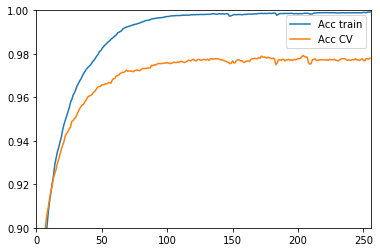

In [54]:
fig, ax = plt.subplots()

x=np.linspace(0,len(acc_CV),num=len(acc))
line1, = ax.plot(x, np.array(acc),label='Acc train')
x=np.arange(len(acc_CV))
line2, = ax.plot(x, np.array(acc_CV),label='Acc CV')
ax.legend()
ax.set(xlim=(0, len(acc_CV)), ylim=(0.9, 1))
plt.show()


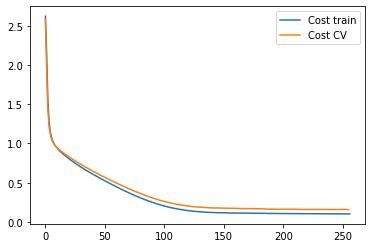

In [55]:
fig, ax = plt.subplots()

x=np.linspace(0,len(cost_CV),num=len(cost))
line1, = ax.plot(x, np.array(cost),label='Cost train')
x=np.arange(len(cost_CV))
line2, = ax.plot(x, np.array(cost_CV),label='Cost CV')
ax.legend()
plt.show()

# Timing at each step
This section measures the time occupied in each task

In [56]:
#Time of feedforward
start = time.time()
number=10
for i in range(number):
    A,Z=feedforward_model(parameters,typeN,x_train)
end = time.time()
print("Time in feedforwards: ", (end - start)/number)

Time in feedforwards:  0.4925177574157715


In [57]:
#Time of backprop
start = time.time()
number=10
for i in range(number):
    grads=backprop_model(parameters,typeN,x_train,Y_train,A,Z)
end = time.time()
print("Time in backprop: ", (end - start)/number)

Time in backprop:  0.5297061920166015


In [58]:
#Time of regularization grad
start = time.time()
number=100
for i in range(number):
    grada=RegularizationL2(parameters,grads,1,m_train)
end = time.time()
print("Time in regularization grad: ", (end - start)/number)

Time in regularization grad:  0.0026728463172912597


In [59]:
#Time of cost and accuracy
start = time.time()
number=100
for i in range(number):
    cost=sigmoid_cost(A[L],Y_train)+RegularizationL2_cost(parameters,1,m_train)
    acc=accuracy(Y2y(A[L]),y_train)
end = time.time()
print("Time in cost and accuracy: ", (end - start)/number)

Time in cost and accuracy:  0.020734241008758546


In [60]:
# Time at ADAM
start = time.time()
number=20
for i in range(number):
    grads1,V1,S1,counter=ADAM_grad(grads,V,S,n_x,n_h,0.9,0.999,1)
end = time.time()
print("Time in backprop: ", (end - start)/number)


Time in backprop:  0.011056232452392577


# Gradient checking
Gradient checking is used to assure backprop is right

In [101]:
def Wb2vector(parameters,name):
    ## This function flattens the parameter dictionary in one column vector
    ## INPUTS:
    ##### parameters: parameters of all the layers ("W_" and "b_")
    ##### name: list that contains the name of the dictionary keys: ["W","b"] or["dW","db"]
    ## OUTPUTS
    ##### vector: one-column vector with parameters flattened
    L=len(parameters)//2

    vector=parameters[name[0]+str(1)].reshape(-1,1)
    vector=np.vstack((vector,parameters[name[1]+str(1)].reshape(-1,1)))
    if L>1:
        for l in range(2,L+1):
            vector=np.vstack((vector,parameters[name[0]+str(l)].reshape(-1,1)))
            vector=np.vstack((vector,parameters[name[1]+str(l)].reshape(-1,1)))
    return vector

def vector2Wb(parameters, vector,name):
    ## This function undo Wb2vector
    ## INPUTS:
    ##### parameters: parameters of all the layers ("W_" and "b_")
    ##### vector: one-column vector with parameters flattened
    ##### name: list that contains the name of the dictionary keys: ["W","b"] or["dW","db"]
    ## OUTPUTS
    ##### parameters: parameters of all the layers ("W_" and "b_")
    L=len(parameters)//2
    parameters_aux={}
    cont=0
    nf=parameters[name[0]+str(1)].shape[0]
    nc=parameters[name[0]+str(1)].shape[1]
    parameters_aux[name[0]+str(1)]=vector[cont:cont+nf*nc].reshape(nf,nc)
    cont+=nf*nc
    nf=parameters[name[1]+str(1)].shape[0]
    nc=parameters[name[1]+str(1)].shape[1]
    parameters_aux[name[1]+str(1)]=vector[cont:cont+nf*nc].reshape(nf,nc)
    cont+=nf*nc
    if L>1:
        for l in range(2,L+1):
            nf=parameters[name[0]+str(l)].shape[0]
            nc=parameters[name[0]+str(l)].shape[1]
            parameters_aux[name[0]+str(l)]=vector[cont:cont+nf*nc].reshape(nf,nc)
            cont+=nf*nc
            nf=parameters[name[1]+str(l)].shape[0]
            nc=parameters[name[1]+str(l)].shape[1]
            parameters_aux[name[1]+str(l)]=vector[cont:cont+nf*nc].reshape(nf,nc)
            cont+=nf*nc
    return parameters_aux

# Creation of dummy parameters, xx and yy
parameters={}
parameters["W1"]=np.random.rand(4,5)
parameters["W2"]=np.random.rand(3,4)
parameters["W3"]=np.random.rand(10,3)
parameters["b1"]=np.random.rand(4,1)
parameters["b2"]=np.random.rand(3,1)
parameters["b3"]=np.random.rand(10,1)
xx=np.random.rand(5,10)
yy_aux=np.random.randint(0,10,(1,10))
yy=np.zeros((10,yy_aux.shape[1]))
yy[yy_aux,range(yy_aux.shape[1])]=1

lambda_regularization=1

# Cost function
loss=loss_function(typeN) 

# feedforward+backprop
m_xx=xx.shape[1]
A,Z=feedforward_model(parameters,typeN,xx)
costs_f=loss(A[L],yy)+RegularizationL2_cost(parameters,lambda_regularization,m_xx)
grads=backprop_model(parameters,typeN,xx,yy,A,Z)
grads=RegularizationL2(parameters,grads,lambda_regularization,m_xx)
grads_V=Wb2vector(grads,["dW","db"])


# Gradient checking
V=Wb2vector(parameters,["W","b"])
d=V.shape[0]
grad_approx=np.zeros((d,1))
epsilon=0.000001
for i in range(d):
    aux=np.copy(V)
    aux[i]=aux[i]+epsilon
    parameters_aux=vector2Wb(parameters, aux,["W","b"])
    A,Z=feedforward_model(parameters_aux,typeN,xx)
    cost_aux_P=loss(A[L],yy)+RegularizationL2_cost(parameters_aux,lambda_regularization,m_xx)
    aux=np.copy(V)
    aux[i]=aux[i]-epsilon
    parameters_aux=vector2Wb(parameters, aux,["W","b"])
    A,Z=feedforward_model(parameters_aux,typeN,xx)
    cost_aux_N=loss(A[L],yy)+RegularizationL2_cost(parameters_aux,lambda_regularization,m_xx)
    grad_approx[i]=(cost_aux_P-cost_aux_N)/(2*epsilon)
    
maximum_difference=((np.abs(grad_approx-grads_V))/grads_V).max()
print("Maximum difference between vectors is: %f·10^(-7)" %(maximum_difference*1e7))
#print(np.hstack((grads_V.reshape(-1,1),grad_approx.reshape(-1,1))))


Maximum difference between vectors is: 0.210344·10^(-7)
